#### QCNN Initialisation

In [2]:
import json
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.circuit import ParameterVector
from qiskit.circuit.library import ZFeatureMap
from qiskit.quantum_info import SparsePauliOp
from qiskit_algorithms.optimizers import COBYLA
from qiskit_algorithms.utils import algorithm_globals
from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier
from qiskit_machine_learning.neural_networks import EstimatorQNN, SamplerQNN
from sklearn.model_selection import train_test_split

algorithm_globals.random_seed = 12345

def conv_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)
    target.cx(1, 0)
    target.rz(np.pi / 2, 0)
    return target


# Let's draw this circuit and see what it looks like
params = ParameterVector("θ", length=3)
circuit = conv_circuit(params)
circuit.draw("mpl", style="clifford")

def conv_layer(num_qubits, param_prefix):
    qc = QuantumCircuit(num_qubits, name="Convolutional Layer")
    qubits = list(range(num_qubits))
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits * 3)
    for q1, q2 in zip(qubits[0::2], qubits[1::2]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        qc.barrier()
        param_index += 3
    for q1, q2 in zip(qubits[1::2], qubits[2::2] + [0]):
        qc = qc.compose(conv_circuit(params[param_index : (param_index + 3)]), [q1, q2])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, qubits)
    return qc


circuit = conv_layer(4, "θ")
circuit.decompose().draw("mpl", style="clifford")

def pool_circuit(params):
    target = QuantumCircuit(2)
    target.rz(-np.pi / 2, 1)
    target.cx(1, 0)
    target.rz(params[0], 0)
    target.ry(params[1], 1)
    target.cx(0, 1)
    target.ry(params[2], 1)

    return target


params = ParameterVector("θ", length=3)
circuit = pool_circuit(params)
circuit.draw("mpl", style="clifford")



def pool_layer(sources, sinks, param_prefix):
    num_qubits = len(sources) + len(sinks)
    qc = QuantumCircuit(num_qubits, name="Pooling Layer")
    param_index = 0
    params = ParameterVector(param_prefix, length=num_qubits // 2 * 3)
    for source, sink in zip(sources, sinks):
        qc = qc.compose(pool_circuit(params[param_index : (param_index + 3)]), [source, sink])
        qc.barrier()
        param_index += 3

    qc_inst = qc.to_instruction()

    qc = QuantumCircuit(num_qubits)
    qc.append(qc_inst, range(num_qubits))
    return qc




#### Loading Featuremap

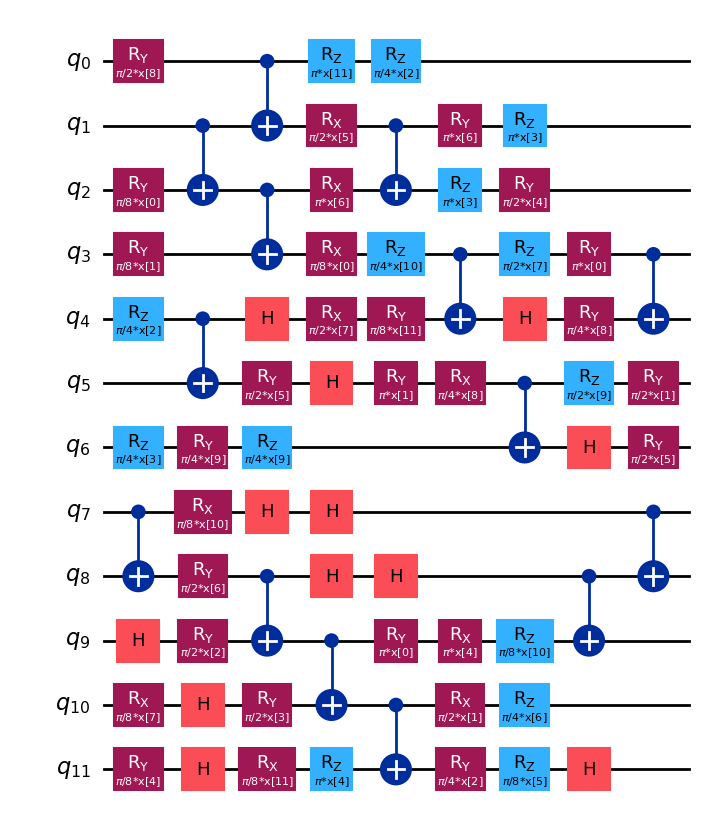

In [10]:
from qiskit import qpy
with open('circuit_3.qpy', 'rb') as handle:
    qc = qpy.load(handle)
 
qc[0].draw('mpl')

#### Curating the data

##### Load transcription

In [ ]:
from sklearn.model_selection import train_test_split
from qiskit_algorithms.utils import algorithm_globals
import json

algorithm_globals.random_seed = 123
import pickle
FOLDER_NAME = './'
with open(FOLDER_NAME+'combined_files.json', 'rb') as fp:
    allDataAnnotation = json.load(fp)


print(allDataAnnotation.keys())
alist , alabel = allDataAnnotation.keys(), allDataAnnotation.values()
# In[4]:


allVidList = []
allVidLab = []
allVidList.extend(alist)

allVidLab.extend(alabel)

#converted_video_names = convert_video_names(allVidList)

allAudioFeatures = {}
failedList = []
train_features, test_features, train_labels, test_labels = train_test_split(
    allVidLab,allVidList, train_size=0.8, random_state=algorithm_globals.random_seed
)

In [ ]:
def convert_video_names(names):
    converted_names = []
    for name in names:
        if name.find("non_hate") == -1:
            print(name)
        #if name.startswith('non_hate_video'):
            converted_names.append(1)
        else:
            converted_names.append(0)
    return converted_names

converted_video_names_test = convert_video_names(test_labels)
converted_video_names_train = convert_video_names(train_labels)

In [ ]:
import pickle
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np


# Function to load pickled MFCC files
def load_jsons(filepath1, filepath2, filepath3):
    # Initialize an empty dictionary to store the combined data
    combined_data = {}

    # Load data from the first JSON file
    with open(filepath1, 'r') as f:
        data1 = json.load(f)
        combined_data.update(data1)

    # Load data from the second JSON file
    with open(filepath2, 'r') as f:
        data2 = json.load(f)
        combined_data.update(data2)

    # Load data from the third JSON file
    with open(filepath3, 'r') as f:
        data3 = json.load(f)
        combined_data.update(data3)

    return combined_data

def get_audio_from_dict(video_names, mfcc_dict):
    audio_list = []
    for name in video_names:
        if name in mfcc_dict:
            print(np.array(mfcc_dict[name]).shape)
            audio_list.append(mfcc_dict[name])
        else:
            print(f"Warning: No MFCC found for {name}")
            audio_list.append(np.zeros((1024,)).tolist())  # or handle missing data as needed
    return audio_list

In [ ]:
audio_features = load_jsons('embeddings_s.json','embeddings_a.json','embeddings_r.json')
#print(mfcc_features)
# Preprocess and map MFCC features to embeddings (or directly use them)
#processed_mfcc = map_mfcc_to_embeddings(mfcc_features)  # Replace `embeddings` with actual embeddings if available
audio_train = get_audio_from_dict(train_labels, audio_features)

In [ ]:
import numpy as np

def get_vid_from_dict(video_names, mfcc_dict):
    mfcc_list = []
    for name in video_names:
        if name in mfcc_dict:
            # Assuming each entry in mfcc_dict[name] is a list or array of MFCC features
            mfcc_list.append(np.array(mfcc_dict[name]).reshape(-1, 40)[0])  # Reshape to (1, 10) array if necessary
        else:
            #print(f"Warning: No MFCC found for {name}")
            # Handle missing data: Use zeros or any other placeholder
            mfcc_list.append(np.zeros(40))  # Assuming MFCC vector dimension is 10
            # mfcc_list.append(None)  # Alternatively, you could append None if you prefer

    return np.array(mfcc_list)


In [ ]:
audio_features = load_jsons('embeddings_s.json','embeddings_a.json','embeddings_r.json')
#print(mfcc_features)
# Preprocess and map MFCC features to embeddings (or directly use them)
#processed_mfcc = map_mfcc_to_embeddings(mfcc_features)  # Replace `embeddings` with actual embeddings if available


In [ ]:
import pickle
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np

# Load FastText embeddings from .p file
with open('train_embeddings.p', 'rb') as f:
    embeddings = pickle.load(f)

# Example text data
file_path = 'all_video_features.p'
with open(file_path, 'rb') as f:
    data = pickle.load(f)
vid_train = get_vid_from_dict(train_labels,data)

# Preprocess your text (tokenization, lowercasing, etc.)
def preprocess_text(text):
    return text.lower().split()

# Function to map words to embeddings
def map_text_to_embeddings(text, embeddings):
    embeddings_list = []
    for token in text:
        
        if token in embeddings:
            embeddings_list.append(embeddings[token])
        else:
            embeddings_list.append(np.zeros(len(next(iter(embeddings.values())))))  # Zero vector for OOV tokens
    return np.mean(embeddings_list, axis=0) if embeddings_list else np.zeros(len(next(iter(embeddings.values()))))

# Preprocess and map text to embeddings
processed_texts = [map_text_to_embeddings(preprocess_text(text), embeddings) for text in train_features]

# Example SVC classifier pipeline

# Example labels for binary classification
labels = converted_video_names_train
#print(processed_texts)
# Fit SVC classifier

combined_train = np.hstack((processed_texts,audio_train,vid_train))

In [ ]:
with open('test_embeddings.p', 'rb') as f:
    embeddings = pickle.load(f)
processed_test_texts = [map_text_to_embeddings(preprocess_text(text), embeddings) for text in test_features]
# Predict labels using trained SVC classifier
#predicted_labels = svc_pipeline.predict(processed_test_texts)

In [ ]:
audio_test = get_audio_from_dict(test_labels, audio_features)
vid_test = get_vid_from_dict(test_labels,data)
combined_test = np.hstack((processed_test_texts,audio_test,vid_test))

In [ ]:
import pandas as pd
train = pd.DataFrame(combined_train)
train['y'] = converted_video_names_train
train.to_csv("AllTrain.csv")

In [ ]:
import pandas as pd
test = pd.DataFrame(combined_test)
test['y'] = converted_video_names_test
test.to_csv("AllTest.csv")

#### Loading Curated Data

In [ ]:
import pandas as pd
train= pd.read_csv("AllTrain.csv")
test = pd.read_csv("AllTest.csv")

#### Data Transformation

In [ ]:
from umap import UMAP
umap_fit = UMAP(n_components=12,n_neighbors=24,random_state=0)

2024-08-02 19:07:10.822062: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-08-02 19:07:10.939827: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-02 19:07:10.982467: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-02 19:07:10.993386: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-02 19:07:11.079789: I tensorflow/core/platform/cpu_feature_guar

In [ ]:
tr = umap_fit.fit_transform(train.drop(['y'],axis=1))

/home/admin-pc/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


In [ ]:
te = umap_fit.transform(test.drop(['y'],axis=1))

In [11]:
feature_map = qc[0]

ansatz = QuantumCircuit(12, name="Ansatz")

# First Convolutional Layer
ansatz.compose(conv_layer(12, "c1"), list(range(12)), inplace=True)

# First Pooling Layer
ansatz.compose(pool_layer([0, 1, 2, 3, 4, 5 ],[6,7,8,9,10,11], "p1"), list(range(12)), inplace=True)
ansatz.compose(conv_layer(8, "c2"), list(range(4,12)), inplace=True)

# Second Pooling Layer
ansatz.compose(pool_layer([0, 1, 2, 3], [4, 5, 6, 7], "p2"), list(range(4,12)), inplace=True)


# Second Convolutional Layer
ansatz.compose(conv_layer(4, "c3"), list(range(8,12)), inplace=True)

# Second Pooling Layer
ansatz.compose(pool_layer([0, 1], [2, 3], "p3"), list(range(8,12)), inplace=True)

# Third Convolutional Layer
ansatz.compose(conv_layer(2, "c4"), list(range(10,12)), inplace=True)

# Third Pooling Layer
ansatz.compose(pool_layer([0], [1], "p4"), list(range(10,12)), inplace=True)

# Combining the feature map and ansatz
circuit = QuantumCircuit(12)
circuit.compose(feature_map, range(12), inplace=True)
circuit.compose(ansatz, range(12), inplace=True)

observable = SparsePauliOp.from_list([("Z" + "I" * 11, 1)])

# we decompose the circuit for the QNN to avoid additional data copying
qnn = EstimatorQNN(
    circuit=circuit.decompose(),
    observables=observable,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
)



#### Defining the QCNN and Callback graph

In [ ]:

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

In [ ]:
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

from qiskit_algorithms.optimizers import SPSA
classifier = NeuralNetworkClassifier(
    qnn,
    optimizer=COBYLA(maxiter=300),  # Set max iterations here
    callback=callback_graph)

#### Training the QCNN

In [ ]:
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)
#classifier.warm_start = True
#classifier.optimizer = COBYLA(maxiter=150)
classifier.fit(np.array(tr), np.array(train['y']))

In [ ]:
print(classifier.score(tr, np.array(train['y'])))
print(classifier.score(te, np.array(test['y'])))

In [ ]:
classifier.save("allmodel.model")

#### VQC Training for 12 features

In [ ]:
from qiskit_algorithms.utils import algorithm_globals
from qiskit.circuit.library import ZZFeatureMap

num_features = 12

feature_map = qc[0]
feature_map.decompose().draw(output="mpl", style="clifford", fold=1)
from qiskit.circuit.library import RealAmplitudes, EfficientSU2

ansatz = RealAmplitudes(num_qubits=12, reps=3)
ansatz.decompose().draw(output="mpl", style="clifford", fold=20)
from qiskit_algorithms.optimizers import COBYLA, SPSA

optimizer = COBYLA(maxiter=300)

from qiskit.primitives import Sampler

sampler = Sampler()

In [ ]:
from matplotlib import pyplot as plt
from IPython.display import clear_output

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)


def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()


In [ ]:
import time
import numpy as np
from qiskit_machine_learning.algorithms.classifiers import VQC

vqc = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback_graph,
)


#vqc.warm_start = True
#vqc.optimizer = COBYLA(maxiter=50)
# clear objective value history
objective_func_vals = []

start = time.time()
vqc.fit(np.array(tr), np.array(train['y']))
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

In [ ]:
vqc.score(np.array(tr), np.array(train['y']))

In [ ]:
vqc.score(np.array(te), np.array(train['y']))

#### Text + Audio 8 features - QCNN

c:\Users\harip\qiskit\Lib\site-packages\qiskit\qpy\interface.py:305: UserWarning: The qiskit version used to generate the provided QPY file, 1.1.1, is newer than the current qiskit version 1.1.0. This may result in an error if the QPY file uses instructions not present in this current qiskit version
  warnings.warn(


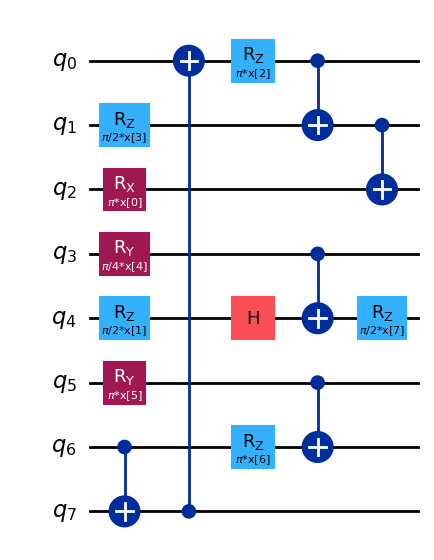

In [1]:
from qiskit import qpy
with open('circuit_new_all_8.qpy', 'rb') as handle:
    qc = qpy.load(handle)
 
qc[0].draw('mpl')

In [ ]:
tr_text_audio = np.hstack((processed_texts,audio_train))
te_text_audio = np.hstack((processed_test_texts,audio_test))

In [ ]:
from umap import UMAP
umap_fit = UMAP(n_components=12,n_neighbors=24,random_state=0)
tr = umap_fit.fit_transform(tr_text_audio)
te = umap_fit.transform(te_text_audio)

In [ ]:
feature_map = qc[0]

ansatz = QuantumCircuit(8, name="Ansatz")

# First Convolutional Layer
ansatz.compose(conv_layer(8, "c1"), list(range(8)), inplace=True)

# First Pooling Layer

ansatz.compose(pool_layer([0, 1, 2, 3], [4, 5, 6, 7], "p1"), list(range(8)), inplace=True)


# Second Convolutional Layer
ansatz.compose(conv_layer(4, "c2"), list(range(4,8)), inplace=True)

# Second Pooling Layer
ansatz.compose(pool_layer([0, 1], [2, 3], "p2"), list(range(4,8)), inplace=True)

# Third Convolutional Layer
ansatz.compose(conv_layer(2, "c3"), list(range(6,8)), inplace=True)

# Third Pooling Layer
ansatz.compose(pool_layer([0], [1], "p3"), list(range(6,8)), inplace=True)

# Combining the feature map and ansatz
circuit = QuantumCircuit(8)
circuit.compose(feature_map, range(8), inplace=True)
circuit.compose(ansatz, range(8), inplace=True)

observable = SparsePauliOp.from_list([("Z" + "I" * 7, 1)])

# we decompose the circuit for the QNN to avoid additional data copying
qnn = EstimatorQNN(
    circuit=circuit.decompose(),
    observables=observable,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
)



In [ ]:

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

In [ ]:
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

from qiskit_algorithms.optimizers import SPSA
classifier = NeuralNetworkClassifier(
    qnn,
    optimizer=COBYLA(maxiter=300),  # Set max iterations here
    callback=callback_graph)

In [ ]:
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)
#classifier.warm_start = True
#classifier.optimizer = COBYLA(maxiter=150)
classifier.fit(np.array(tr), np.array(train['y']))

In [ ]:
print(classifier.score(tr, np.array(train['y'])))
print(classifier.score(te, np.array(test['y'])))

#### Text + Audio 8 features - VQC

In [ ]:
from qiskit_algorithms.utils import algorithm_globals
from qiskit.circuit.library import ZZFeatureMap

num_features = 12

feature_map = qc[0]
feature_map.decompose().draw(output="mpl", style="clifford", fold=1)
from qiskit.circuit.library import RealAmplitudes, EfficientSU2

ansatz = RealAmplitudes(num_qubits=12, reps=3)
ansatz.decompose().draw(output="mpl", style="clifford", fold=20)
from qiskit_algorithms.optimizers import COBYLA, SPSA

optimizer = COBYLA(maxiter=300)

from qiskit.primitives import Sampler

sampler = Sampler()

In [ ]:
from matplotlib import pyplot as plt
from IPython.display import clear_output

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)


def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()


In [ ]:
import time
import numpy as np
from qiskit_machine_learning.algorithms.classifiers import VQC

vqc = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback_graph,
)


#vqc.warm_start = True
#vqc.optimizer = COBYLA(maxiter=50)
# clear objective value history
objective_func_vals = []

start = time.time()
vqc.fit(np.array(tr), np.array(train['y']))
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

In [ ]:
vqc.score(np.array(tr), np.array(train['y']))

In [ ]:
vqc.score(np.array(te), np.array(train['y']))

#### Text + Image 8 features - QCNN

In [ ]:
tr_text_image = np.hstack((processed_texts,vid_train))
te_text_image = np.hstack((processed_test_texts,vid_test))

In [ ]:
from umap import UMAP
umap_fit = UMAP(n_components=12,n_neighbors=24,random_state=0)
tr = umap_fit.fit_transform(tr_text_image)
te = umap_fit.transform(te_text_image)

In [ ]:
feature_map = qc[0]

ansatz = QuantumCircuit(8, name="Ansatz")

# First Convolutional Layer
ansatz.compose(conv_layer(8, "c1"), list(range(8)), inplace=True)

# First Pooling Layer

ansatz.compose(pool_layer([0, 1, 2, 3], [4, 5, 6, 7], "p1"), list(range(8)), inplace=True)


# Second Convolutional Layer
ansatz.compose(conv_layer(4, "c2"), list(range(4,8)), inplace=True)

# Second Pooling Layer
ansatz.compose(pool_layer([0, 1], [2, 3], "p2"), list(range(4,8)), inplace=True)

# Third Convolutional Layer
ansatz.compose(conv_layer(2, "c3"), list(range(6,8)), inplace=True)

# Third Pooling Layer
ansatz.compose(pool_layer([0], [1], "p3"), list(range(6,8)), inplace=True)

# Combining the feature map and ansatz
circuit = QuantumCircuit(8)
circuit.compose(feature_map, range(8), inplace=True)
circuit.compose(ansatz, range(8), inplace=True)

observable = SparsePauliOp.from_list([("Z" + "I" * 7, 1)])

# we decompose the circuit for the QNN to avoid additional data copying
qnn = EstimatorQNN(
    circuit=circuit.decompose(),
    observables=observable,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
)



In [ ]:

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

In [ ]:
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

from qiskit_algorithms.optimizers import SPSA
classifier = NeuralNetworkClassifier(
    qnn,
    optimizer=COBYLA(maxiter=300),  # Set max iterations here
    callback=callback_graph)

In [ ]:
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)
#classifier.warm_start = True
#classifier.optimizer = COBYLA(maxiter=150)
classifier.fit(np.array(tr), np.array(train['y']))

In [ ]:
print(classifier.score(tr, np.array(train['y'])))
print(classifier.score(te, np.array(test['y'])))

#### Text + Image 8 features - VQC

In [ ]:
from qiskit_algorithms.utils import algorithm_globals
from qiskit.circuit.library import ZZFeatureMap

num_features = 12

feature_map = qc[0]
feature_map.decompose().draw(output="mpl", style="clifford", fold=1)
from qiskit.circuit.library import RealAmplitudes, EfficientSU2

ansatz = RealAmplitudes(num_qubits=12, reps=3)
ansatz.decompose().draw(output="mpl", style="clifford", fold=20)
from qiskit_algorithms.optimizers import COBYLA, SPSA

optimizer = COBYLA(maxiter=300)

from qiskit.primitives import Sampler

sampler = Sampler()

In [ ]:
from matplotlib import pyplot as plt
from IPython.display import clear_output

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)


def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()


In [ ]:
import time
import numpy as np
from qiskit_machine_learning.algorithms.classifiers import VQC

vqc = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback_graph,
)


#vqc.warm_start = True
#vqc.optimizer = COBYLA(maxiter=50)
# clear objective value history
objective_func_vals = []

start = time.time()
vqc.fit(np.array(tr), np.array(train['y']))
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

In [ ]:
vqc.score(np.array(tr), np.array(train['y']))

In [ ]:
vqc.score(np.array(te), np.array(train['y']))

#### Audio + Image 8 features - QCNN

In [ ]:
tr_audio_image = np.hstack((audio_train,vid_train))
te_audio_image = np.hstack((audio_test,vid_test))

In [ ]:
from umap import UMAP
umap_fit = UMAP(n_components=12,n_neighbors=24,random_state=0)
tr = umap_fit.fit_transform(tr_audio_image)
te = umap_fit.transform(te_audio_image)

In [ ]:
feature_map = qc[0]

ansatz = QuantumCircuit(8, name="Ansatz")

# First Convolutional Layer
ansatz.compose(conv_layer(8, "c1"), list(range(8)), inplace=True)

# First Pooling Layer

ansatz.compose(pool_layer([0, 1, 2, 3], [4, 5, 6, 7], "p1"), list(range(8)), inplace=True)


# Second Convolutional Layer
ansatz.compose(conv_layer(4, "c2"), list(range(4,8)), inplace=True)

# Second Pooling Layer
ansatz.compose(pool_layer([0, 1], [2, 3], "p2"), list(range(4,8)), inplace=True)

# Third Convolutional Layer
ansatz.compose(conv_layer(2, "c3"), list(range(6,8)), inplace=True)

# Third Pooling Layer
ansatz.compose(pool_layer([0], [1], "p3"), list(range(6,8)), inplace=True)

# Combining the feature map and ansatz
circuit = QuantumCircuit(8)
circuit.compose(feature_map, range(8), inplace=True)
circuit.compose(ansatz, range(8), inplace=True)

observable = SparsePauliOp.from_list([("Z" + "I" * 7, 1)])

# we decompose the circuit for the QNN to avoid additional data copying
qnn = EstimatorQNN(
    circuit=circuit.decompose(),
    observables=observable,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
)



In [ ]:

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

In [ ]:
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

from qiskit_algorithms.optimizers import SPSA
classifier = NeuralNetworkClassifier(
    qnn,
    optimizer=COBYLA(maxiter=300),  # Set max iterations here
    callback=callback_graph)

In [ ]:
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)
#classifier.warm_start = True
#classifier.optimizer = COBYLA(maxiter=150)
classifier.fit(np.array(tr), np.array(train['y']))

In [ ]:
print(classifier.score(tr, np.array(train['y'])))
print(classifier.score(te, np.array(test['y'])))

#### Audio + Image 8 features - VQC

In [ ]:
from qiskit_algorithms.utils import algorithm_globals
from qiskit.circuit.library import ZZFeatureMap

num_features = 12

feature_map = qc[0]
feature_map.decompose().draw(output="mpl", style="clifford", fold=1)
from qiskit.circuit.library import RealAmplitudes, EfficientSU2

ansatz = RealAmplitudes(num_qubits=12, reps=3)
ansatz.decompose().draw(output="mpl", style="clifford", fold=20)
from qiskit_algorithms.optimizers import COBYLA, SPSA

optimizer = COBYLA(maxiter=300)

from qiskit.primitives import Sampler

sampler = Sampler()

In [ ]:
from matplotlib import pyplot as plt
from IPython.display import clear_output

objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)


def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()


In [ ]:
import time
import numpy as np
from qiskit_machine_learning.algorithms.classifiers import VQC

vqc = VQC(
    sampler=sampler,
    feature_map=feature_map,
    ansatz=ansatz,
    optimizer=optimizer,
    callback=callback_graph,
)


#vqc.warm_start = True
#vqc.optimizer = COBYLA(maxiter=50)
# clear objective value history
objective_func_vals = []

start = time.time()
vqc.fit(np.array(tr), np.array(train['y']))
elapsed = time.time() - start

print(f"Training time: {round(elapsed)} seconds")

In [ ]:
vqc.score(np.array(tr), np.array(train['y']))

In [ ]:
vqc.score(np.array(te), np.array(train['y']))